In [1]:
from instrumentdatabaseapi import instrumentdatabaseapi as API

repo = API.Repository(local_repo=".")

In [2]:
print(repo)


URL: https://github.com/PaNOSC-ViNYL/instrument_database.git
local_dir: ./


In [3]:
myinstrument = repo.load("ILL", "ThALES", "HEAD", "mcstas", dep=False)

In [4]:
#print(myinstrument)
myThALES = myinstrument.calculators["ThALES"]
# myThALES.show_components()

import pint

ureg = pint.get_application_registry()

a2 = myinstrument.parameters["ThALES"]["a2"]
a2.energy = 4.98 * ureg.meV

basedir = "/tmp/ThALES_scan/"
myinstrument.set_instrument_base_dir(basedir)

a4 = myinstrument.parameters["ThALES"]["a4"]
a3 = myinstrument.parameters["ThALES"]["a3"]
a3.value = 0 * ureg.degree
a4.value = 60 * ureg.degree

a6 = myinstrument.parameters["ThALES"]["a6"]

dE = 0.05

energy = 4.98

myThALES.settings(ncount=10000000)

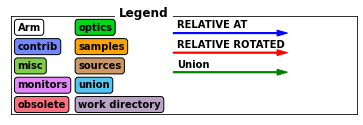

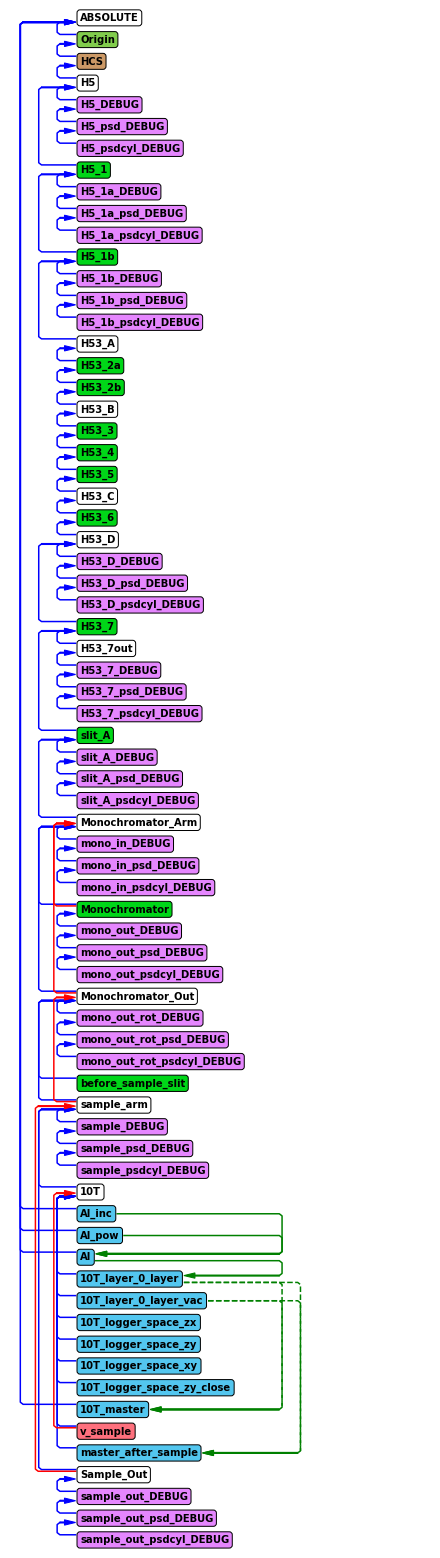

In [5]:
#myThALES.show_diagram()
myThALES.show_diagram()

In [ ]:
myThALES.show_components()

In [6]:
import mcstasscript as ms

In [11]:
print(myinstrument)
#help(ms.Cryostat)
#help(ms.Layer)

######## Instrument ThALES
- Instrument: ThALES -
Calculators:
ThALES
- ParametersCollection object -
  Master Parameters
  a2                                  79.1       [degree]                
  a3                                  0          [degree]                
  a4                                  60         [degree]                
  a6                                  74.34      [degree]                

   ThALES
    - Parameters object -
   a2                                  74.31657289464766 [degree]             Angle between beam reflected by monochromator and incident beam   L[33 degree, 128 degree]
   a3                                  0          [degree]             sample table rotation angle   
   a4                                  60         [degree]             Angle between reflected by sample and incident beams   L[-128 degree, 128 degree]
   a6                                  74.31657289464766 [degree]             Angle between reflected by analyzer and inc

In [7]:
a6.energy = a2.energy
a4.value = 60 * ureg.degree
myThALES.calculator_base_dir = "/tmp/test/" 
data_empty = myThALES.backengine()
#myinstrument.run()

INFO: Using directory: "/tmp/test_1"
INFO: Regenerating c-file: ThALES.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./ThALES.out
mccode-r.c: In function ‘sighandler’:
mccode-r.c:3719:5: warning: implicit declaration of function ‘kill’; did you mean ‘ceill’? [-Wimplicit-function-declaration]
In file included from /usr/local/mcstas/2.7/tools/Python/mcrun/../mccodelib/../../../contrib/union/Incoherent_process.comp:65:
/usr/local/mcstas/2.7/tools/Python/mcrun/../mccodelib/../../../share/Union_functions.c: In function ‘write_tagging_tree’:
/usr/local/mcstas/2.7/tools/Python/mcrun/../mccodelib/../../../share/Union_functions.c:1599:105: warning: passing argument 4 of ‘qsort’ from incompatible pointer type [-Wincompatible-pointer-types]
   qsort(total_history.saved_histories,total_history.used_elements,sizeof (struct saved_history_struct), Sample_compare_history_intensities);
                                                                                                         ^~~~~~~~

In [8]:
ms.name_plot_options("10T_logger_space_zx", data_empty, log=True, orders_of_mag=4)
ms.name_plot_options("10T_logger_space_zy", data_empty, log=True, orders_of_mag=4)

Plotting data with name H5_DEBUG


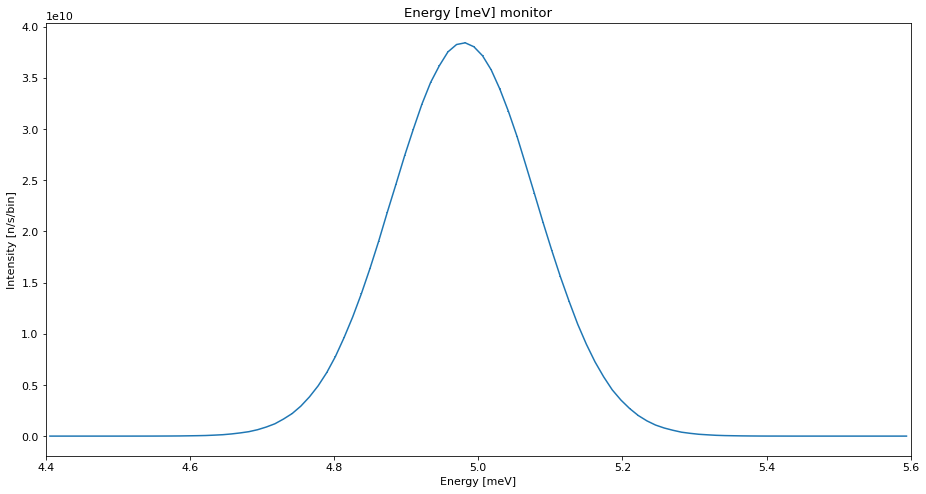

Plotting data with name H5_DEBUG


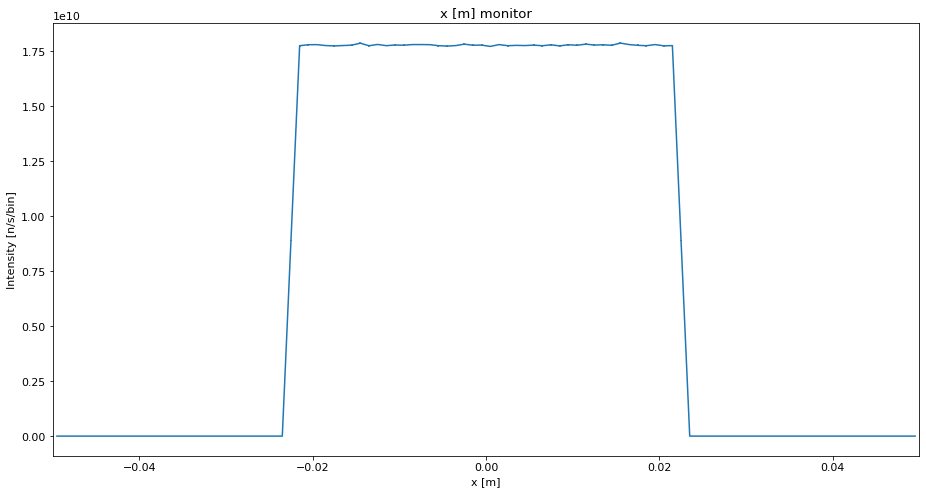

Plotting data with name H5_DEBUG


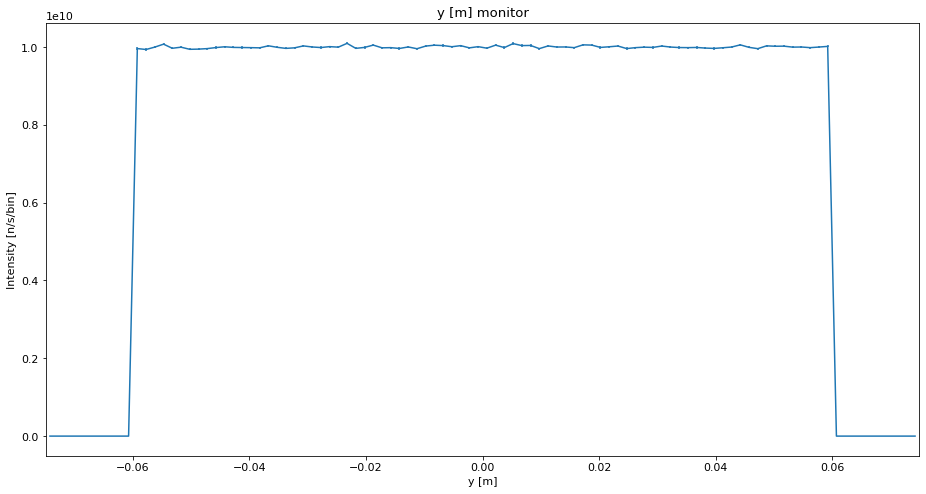

Plotting data with name H5_psd_DEBUG


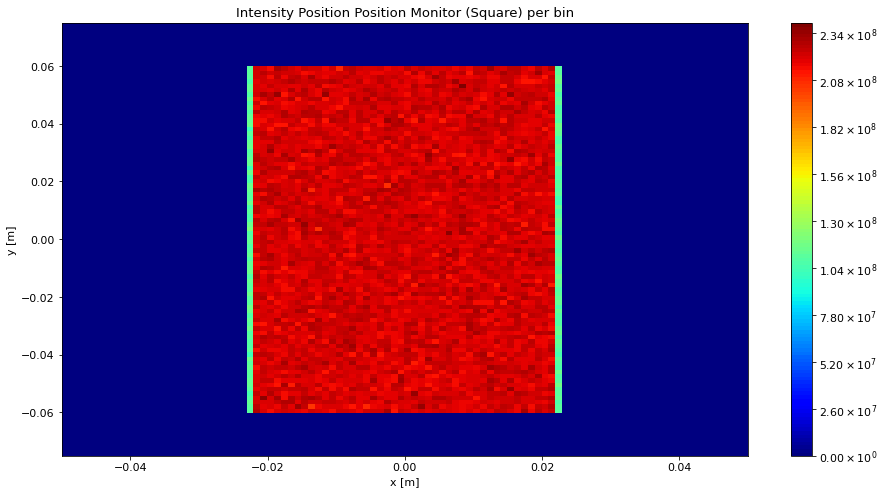

Plotting data with name H5_psdcyl_DEBUG


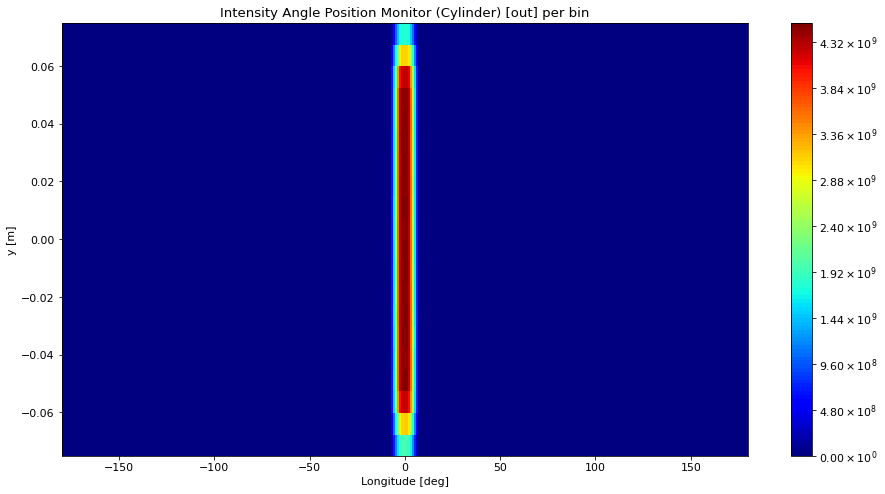

Plotting data with name H5_1a_DEBUG


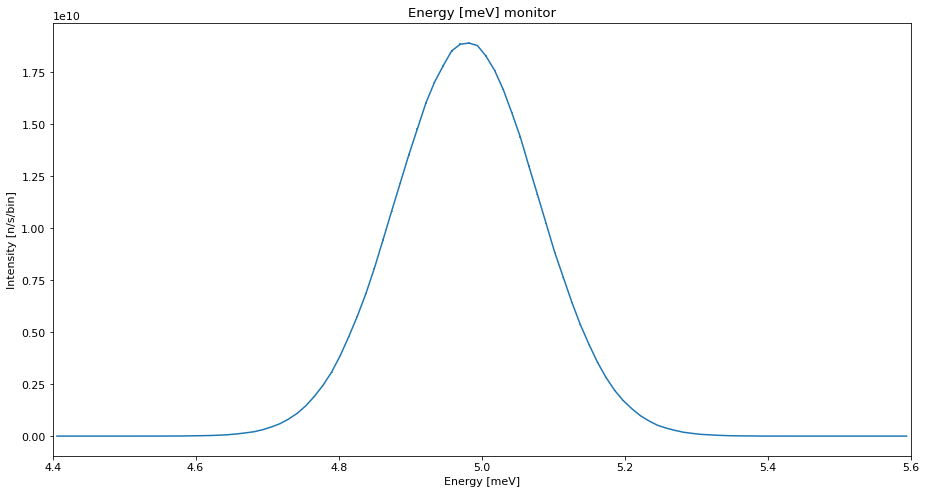

Plotting data with name H5_1a_DEBUG


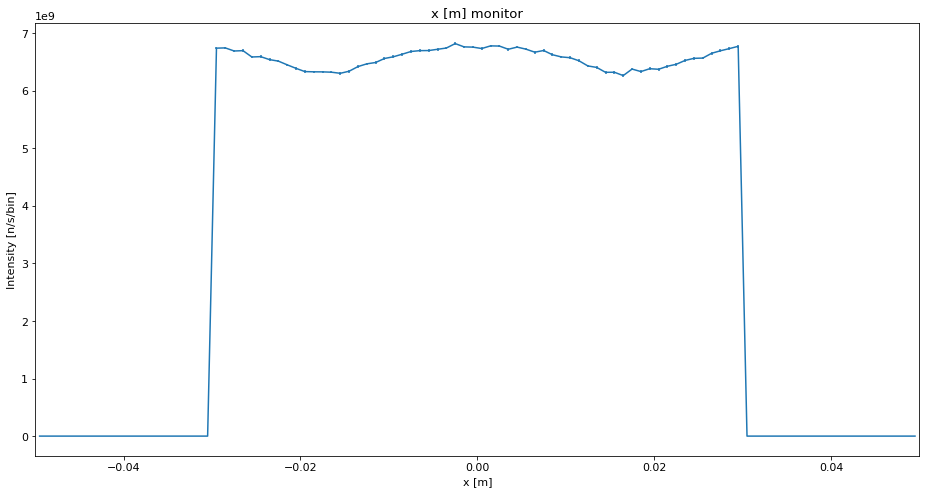

Plotting data with name H5_1a_DEBUG


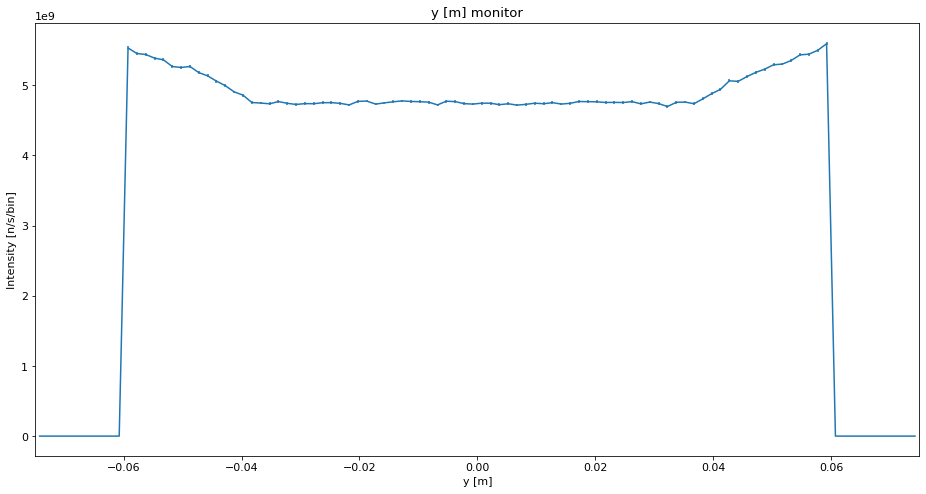

Plotting data with name H5_1a_psd_DEBUG


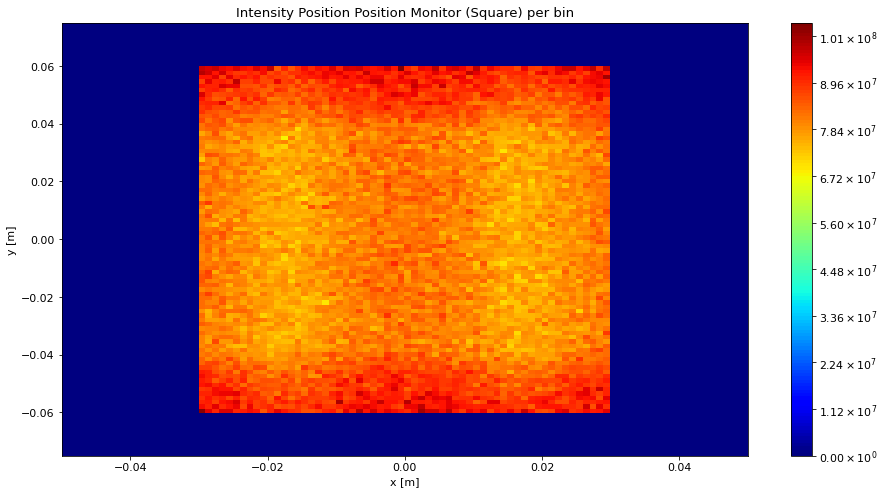

Plotting data with name H5_1a_psdcyl_DEBUG


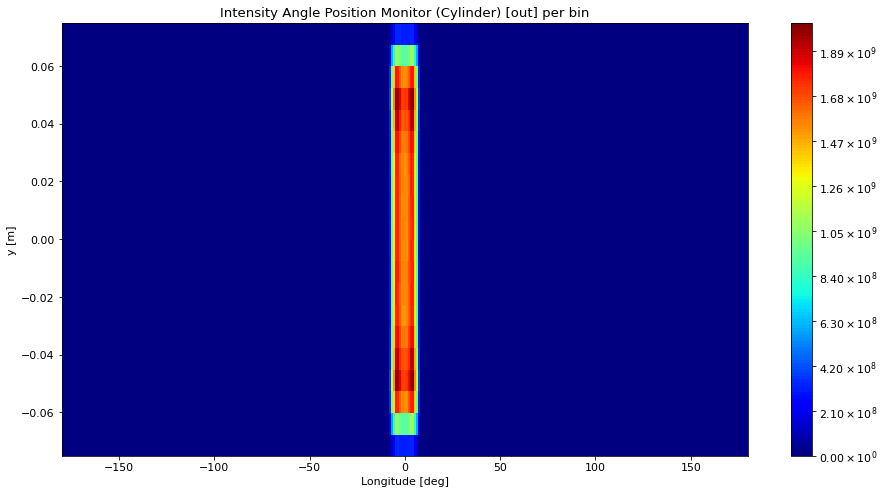

Plotting data with name H5_1b_DEBUG


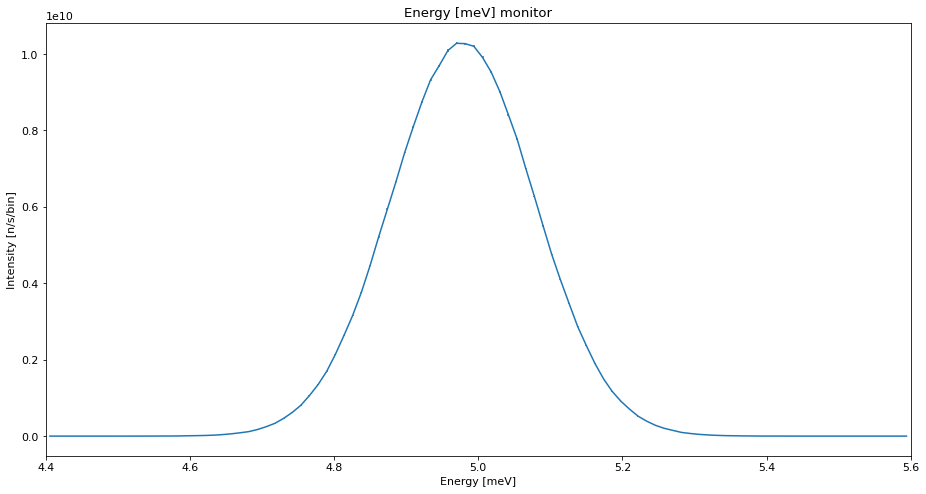

Plotting data with name H5_1b_DEBUG


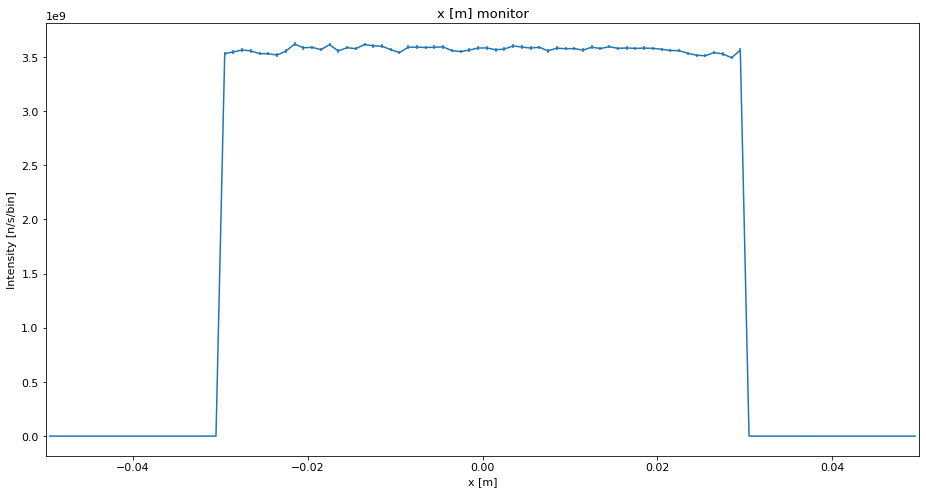

Plotting data with name H5_1b_DEBUG


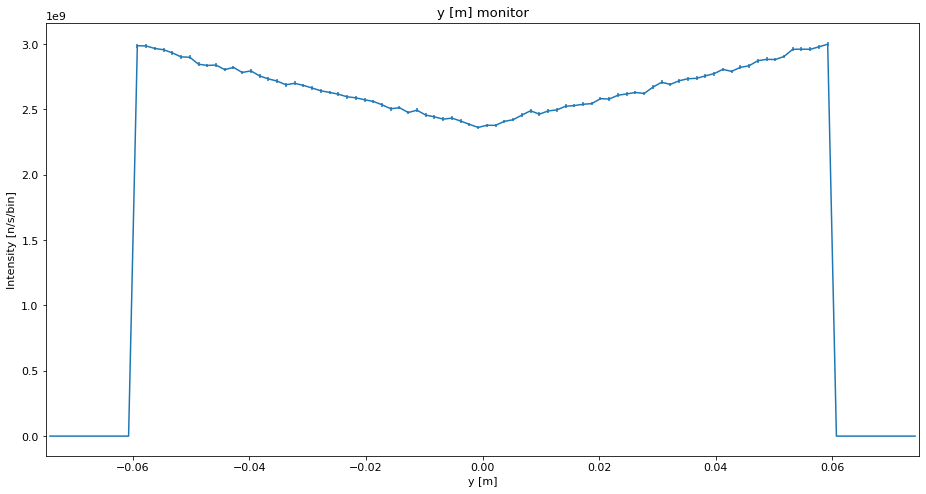

Plotting data with name H5_1b_psd_DEBUG


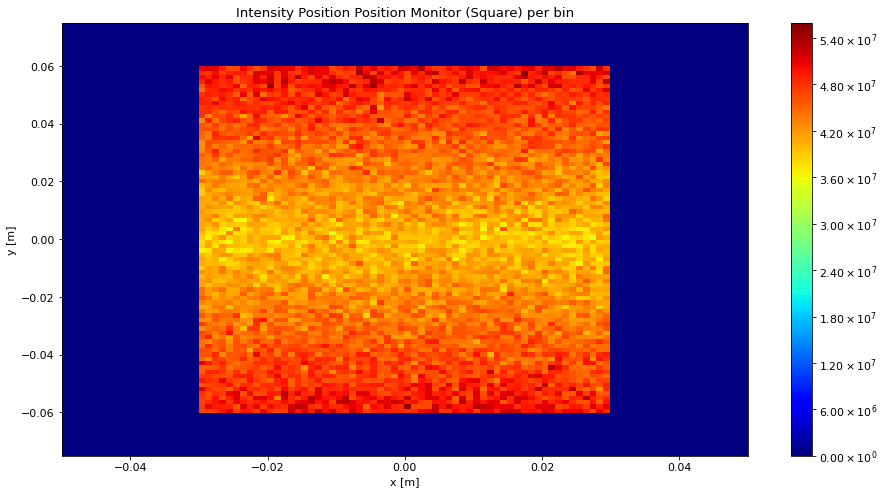

Plotting data with name H5_1b_psdcyl_DEBUG


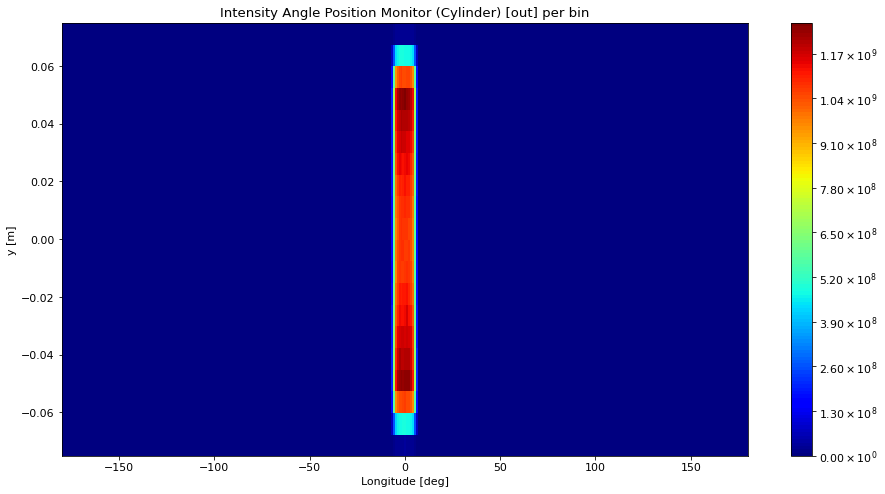

Plotting data with name H53_D_DEBUG


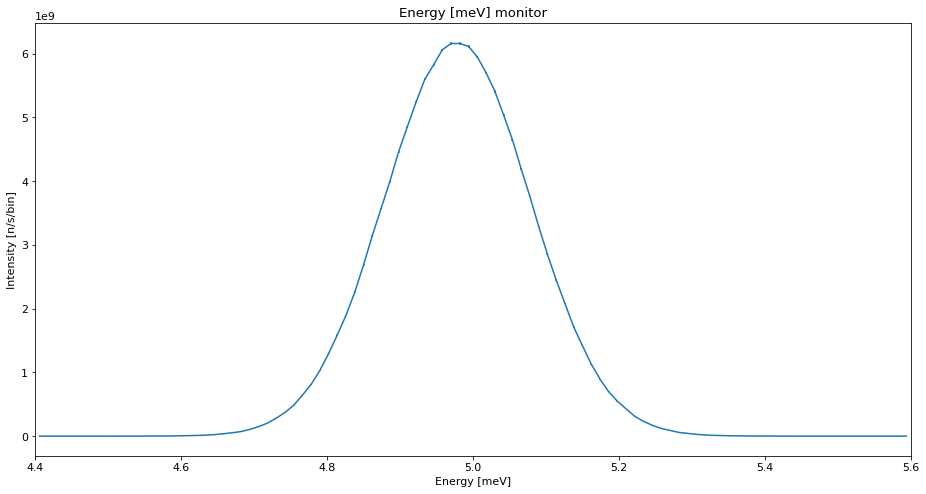

Plotting data with name H53_D_DEBUG


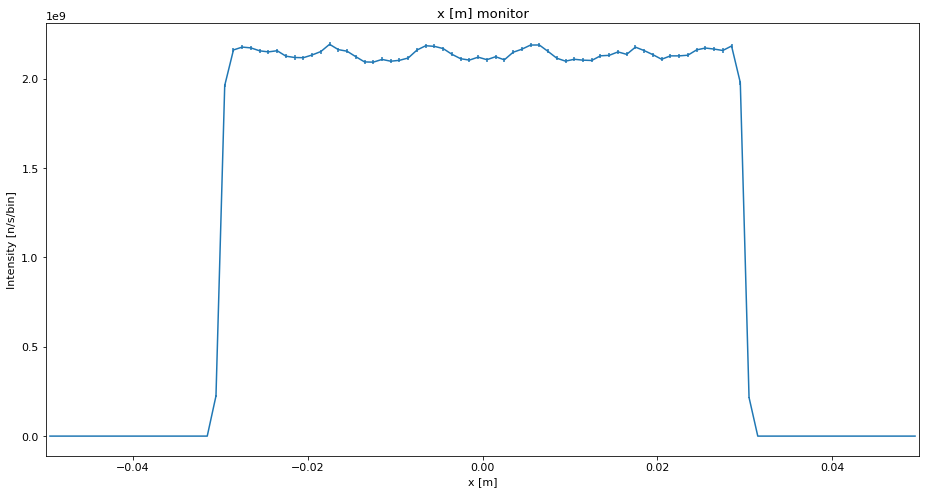

Plotting data with name H53_D_DEBUG


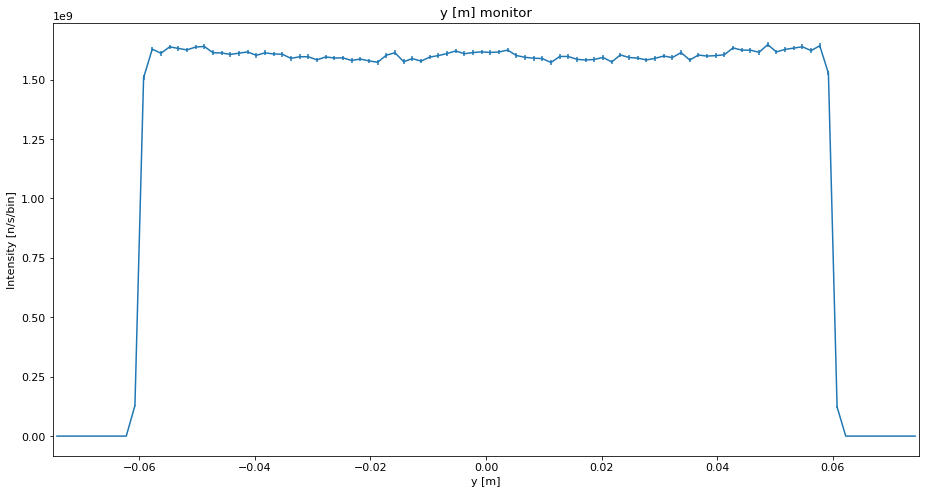

Plotting data with name H53_D_psd_DEBUG


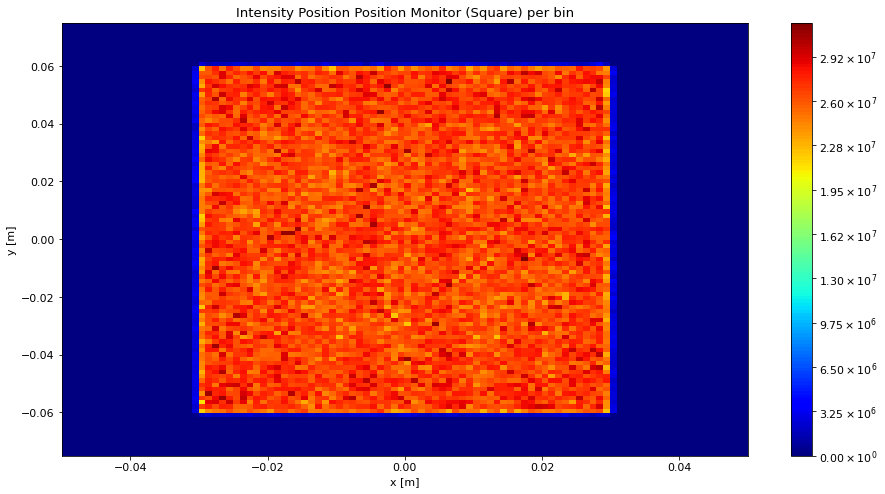

Plotting data with name H53_D_psdcyl_DEBUG


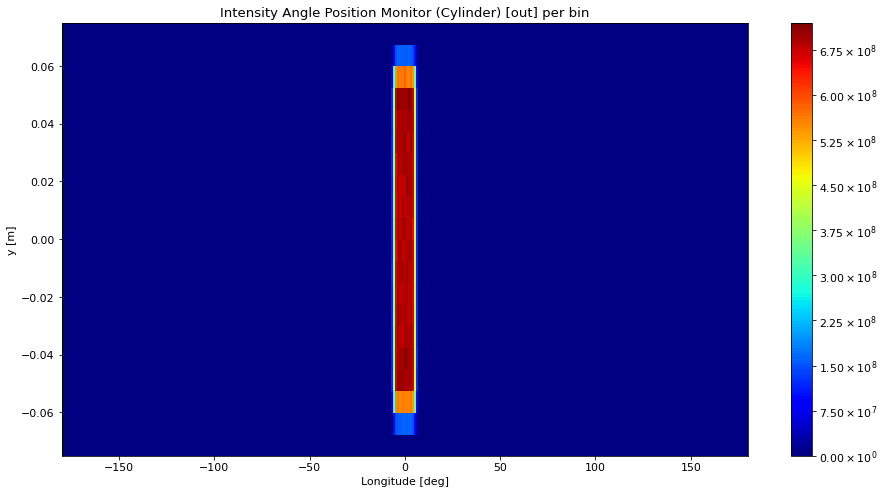

Plotting data with name H53_7_DEBUG


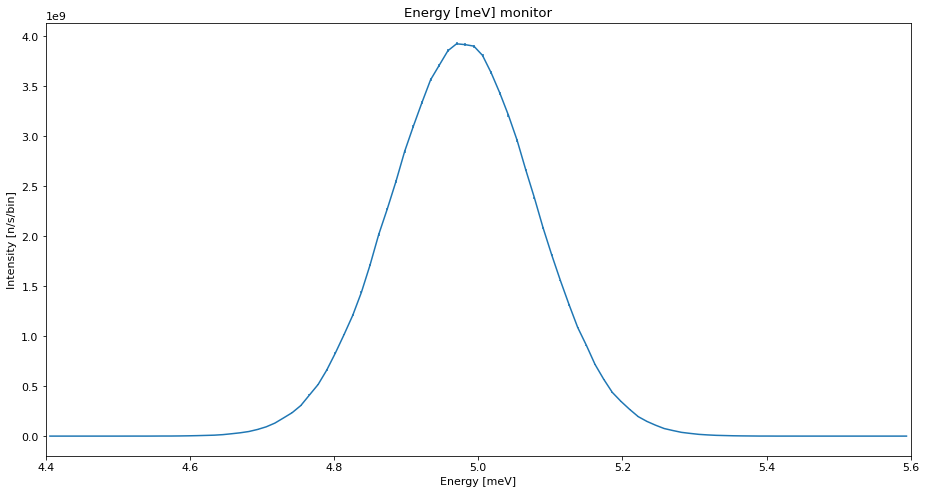

Plotting data with name H53_7_DEBUG


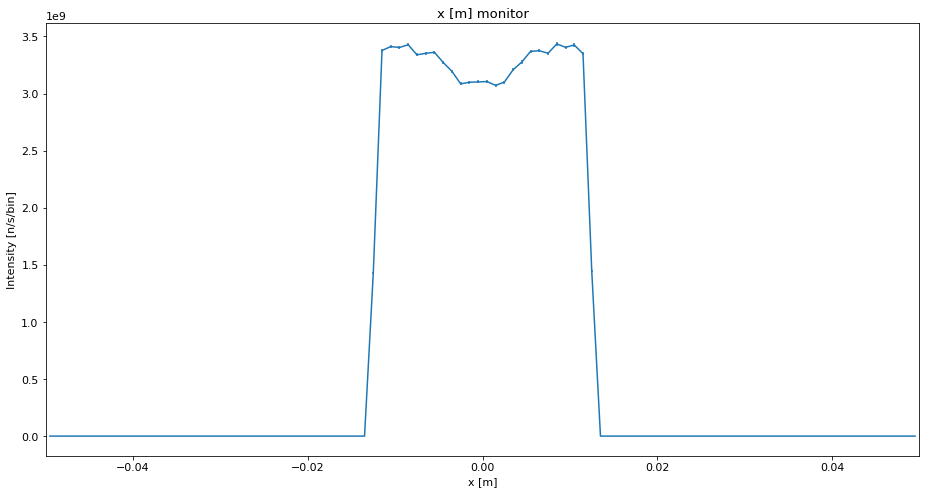

Plotting data with name H53_7_DEBUG


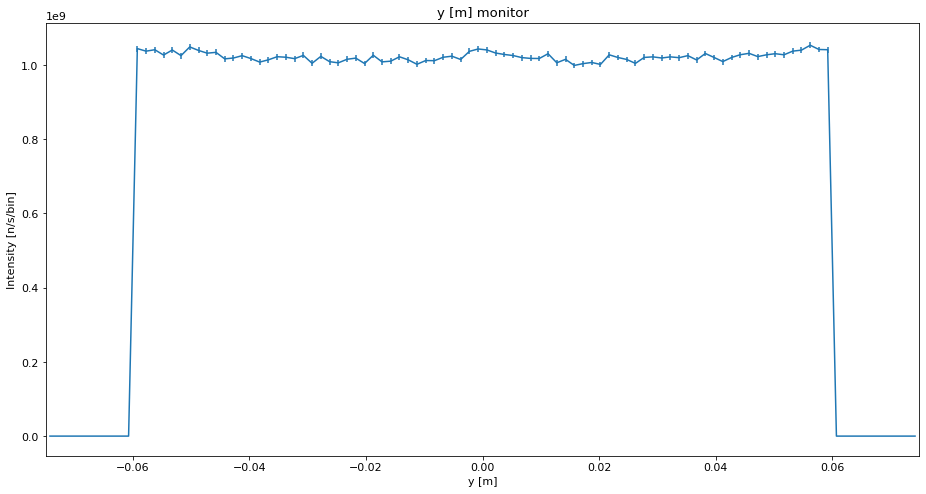

Plotting data with name H53_7_psd_DEBUG


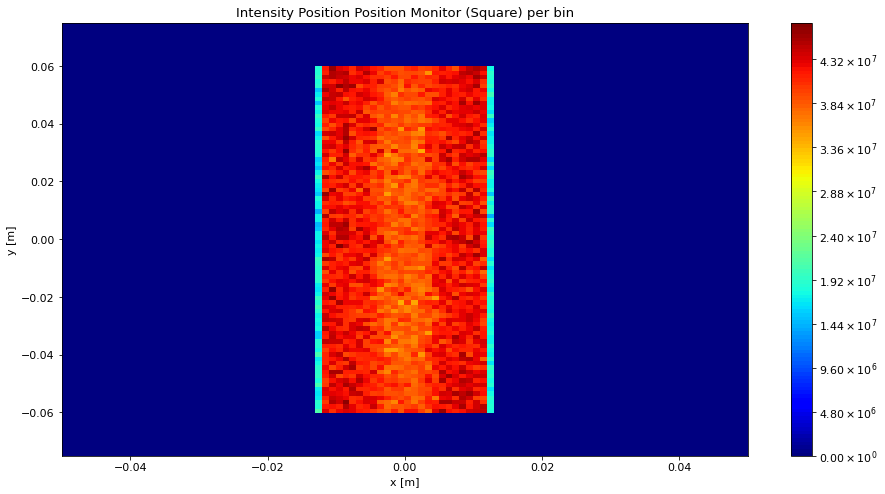

Plotting data with name H53_7_psdcyl_DEBUG


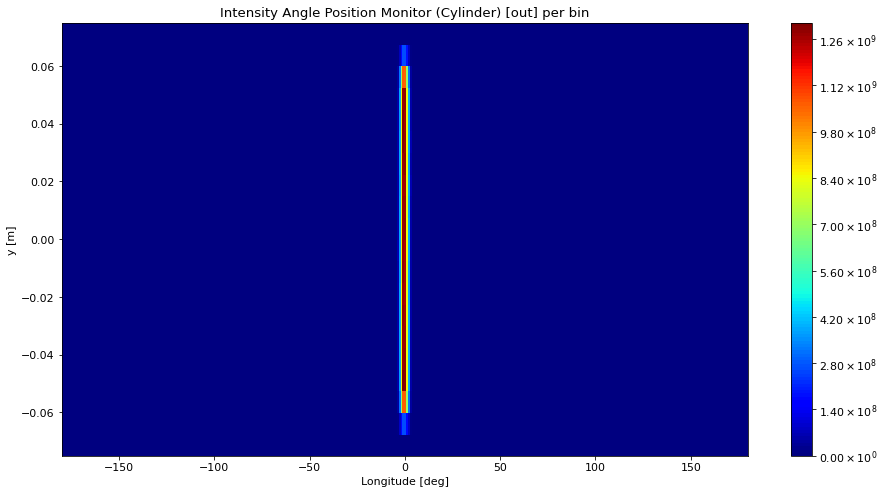

Plotting data with name slit_A_DEBUG


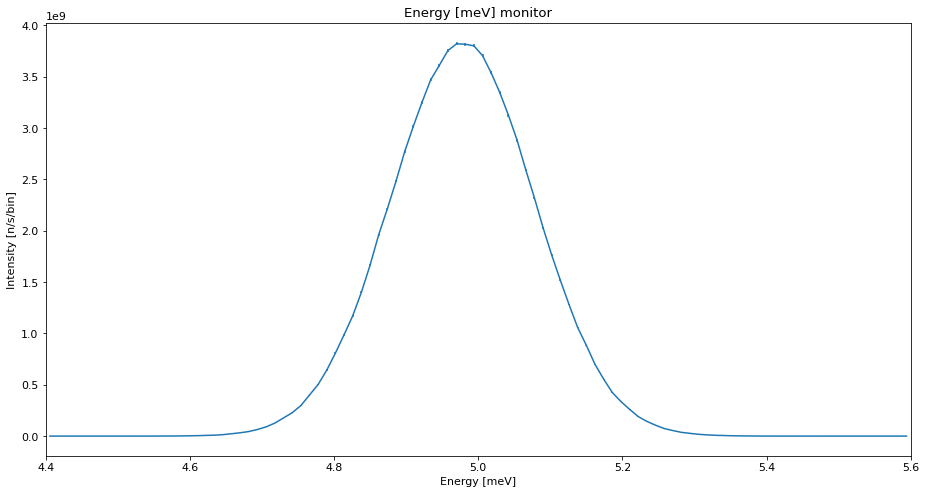

Plotting data with name slit_A_DEBUG


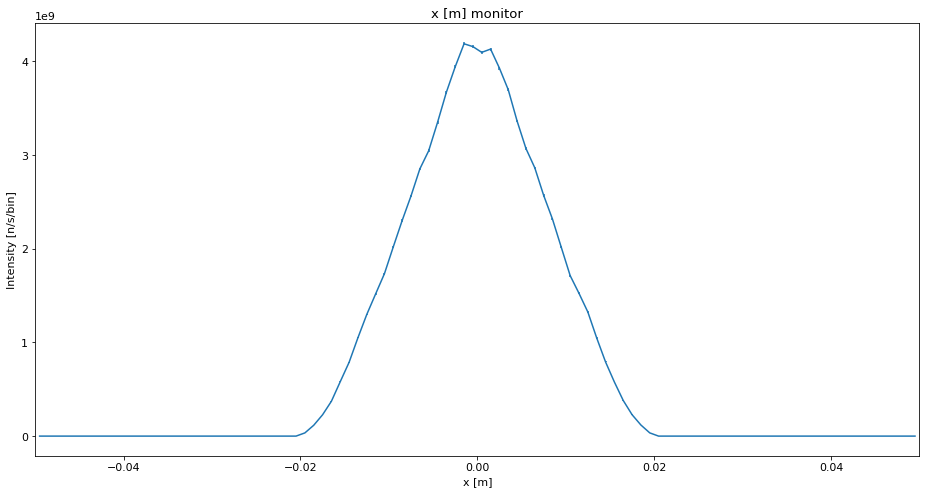

Plotting data with name slit_A_DEBUG


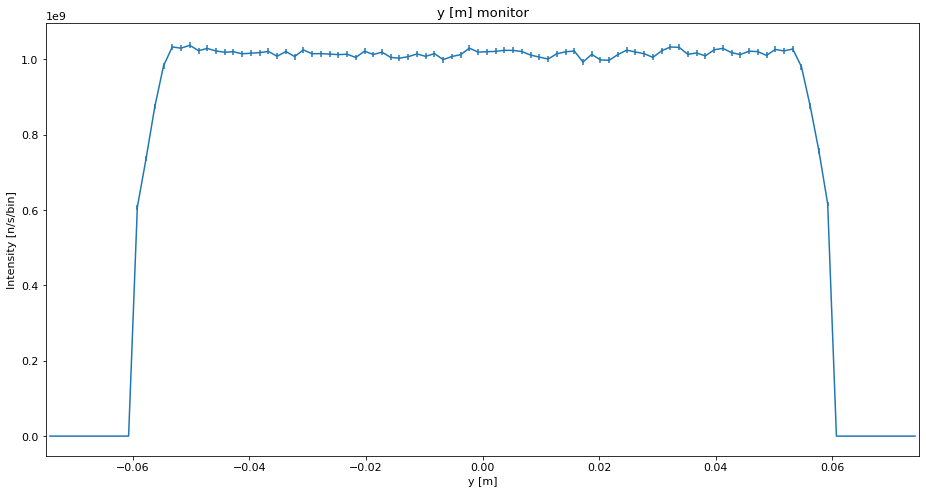

Plotting data with name slit_A_psd_DEBUG


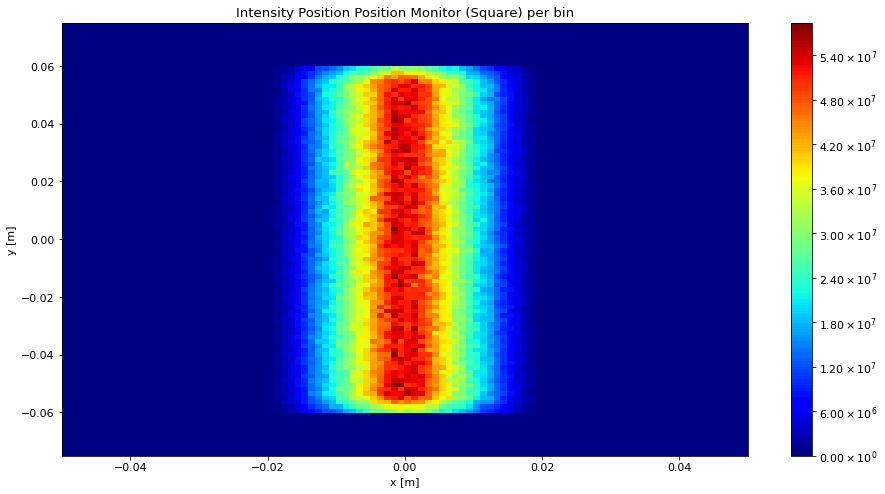

Plotting data with name slit_A_psdcyl_DEBUG


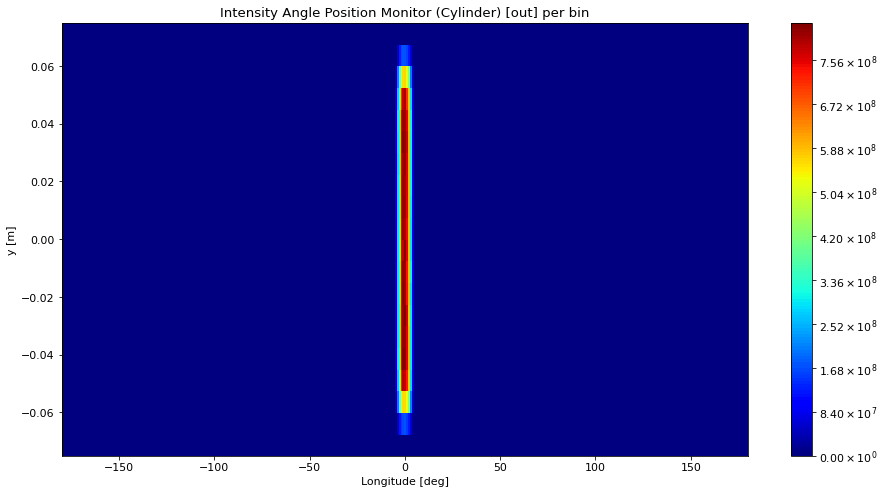

Plotting data with name mono_in_DEBUG


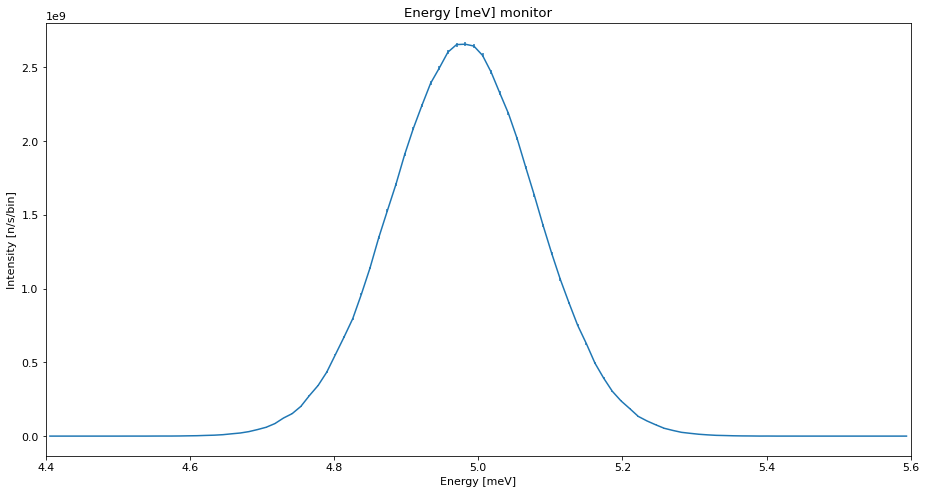

Plotting data with name mono_in_DEBUG


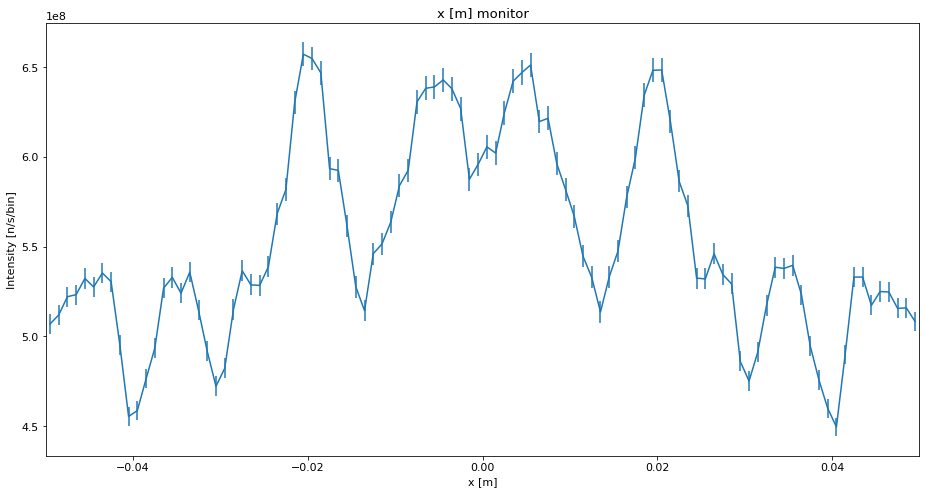

Plotting data with name mono_in_DEBUG


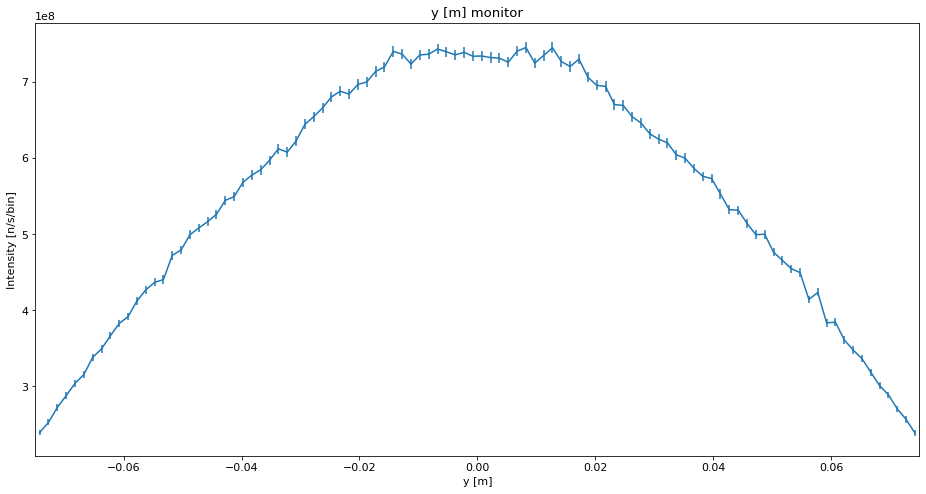

Plotting data with name mono_in_psd_DEBUG


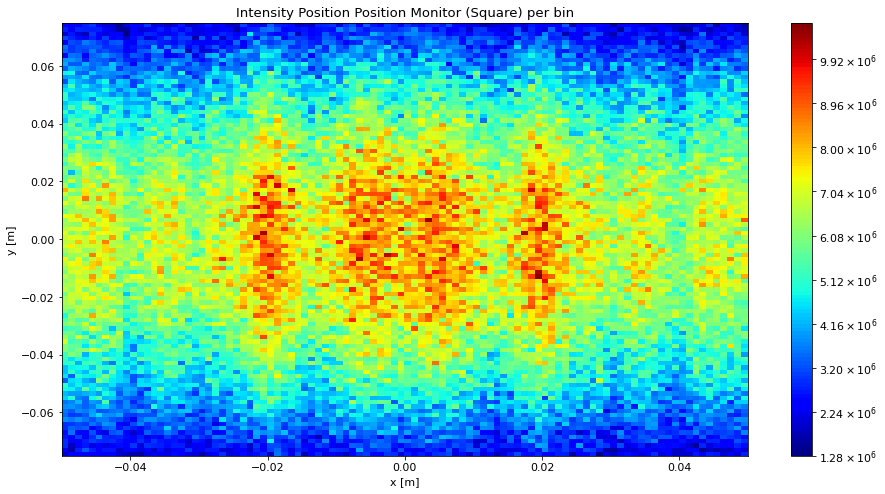

Plotting data with name mono_in_psdcyl_DEBUG


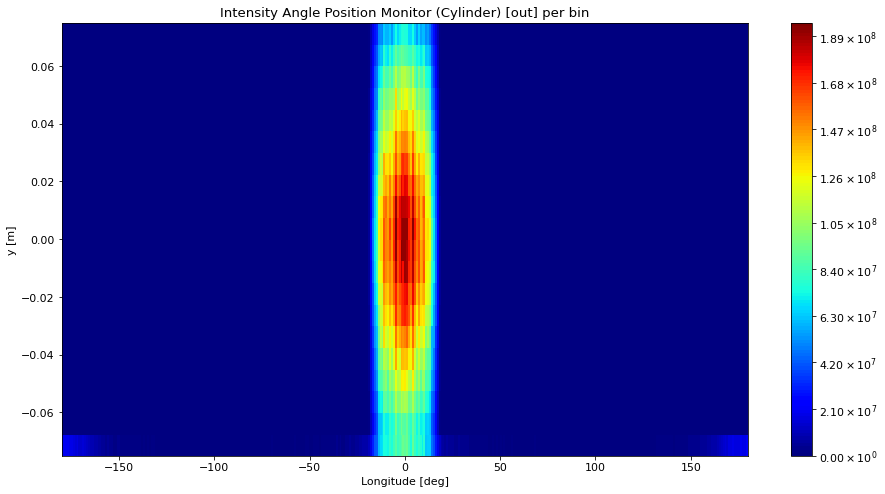

Plotting data with name mono_out_DEBUG


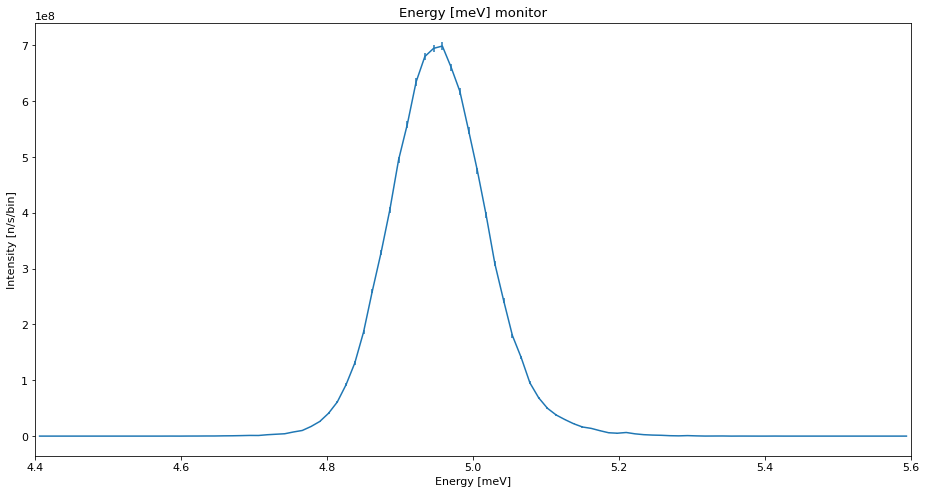

Plotting data with name mono_out_DEBUG


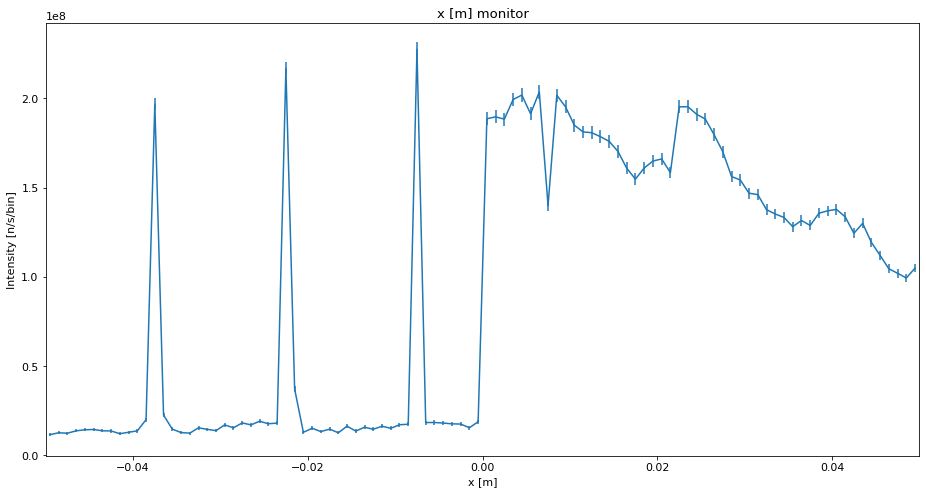

Plotting data with name mono_out_DEBUG


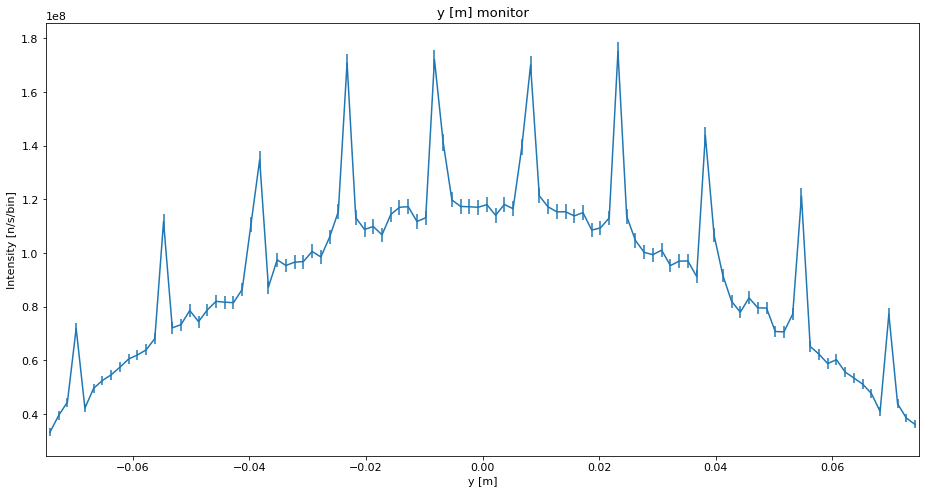

Plotting data with name mono_out_psd_DEBUG


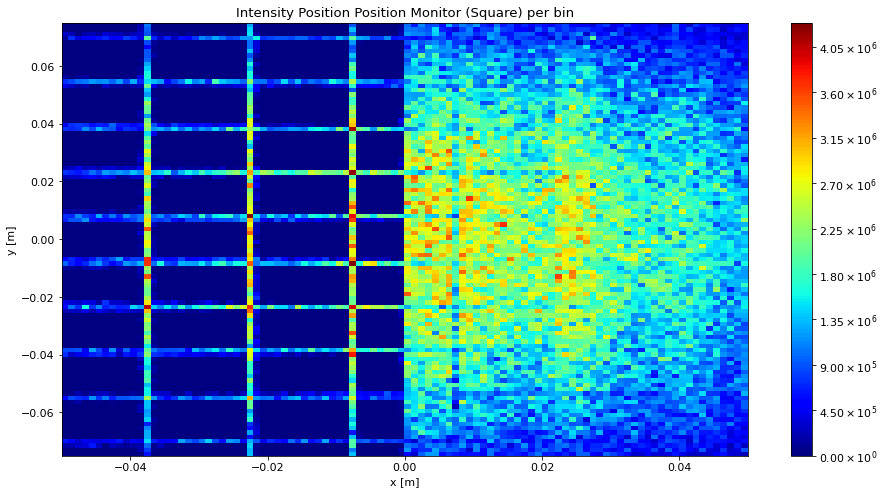

Plotting data with name mono_out_psdcyl_DEBUG


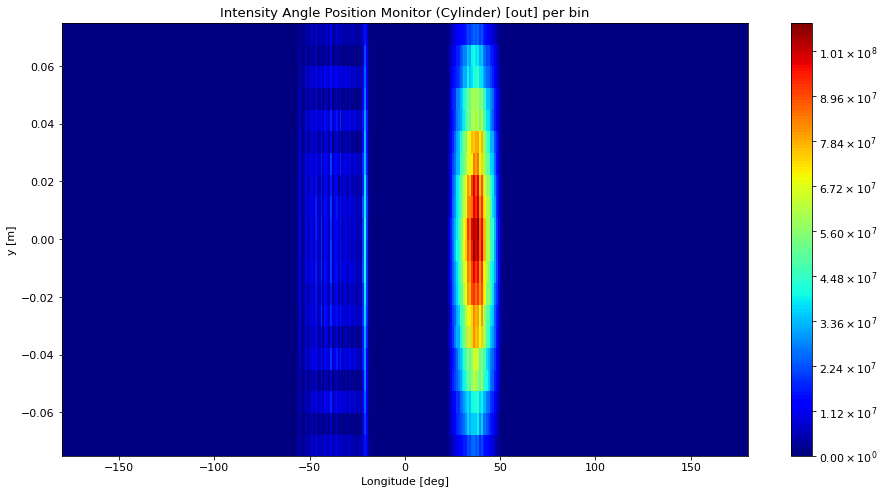

Plotting data with name mono_out_rot_DEBUG


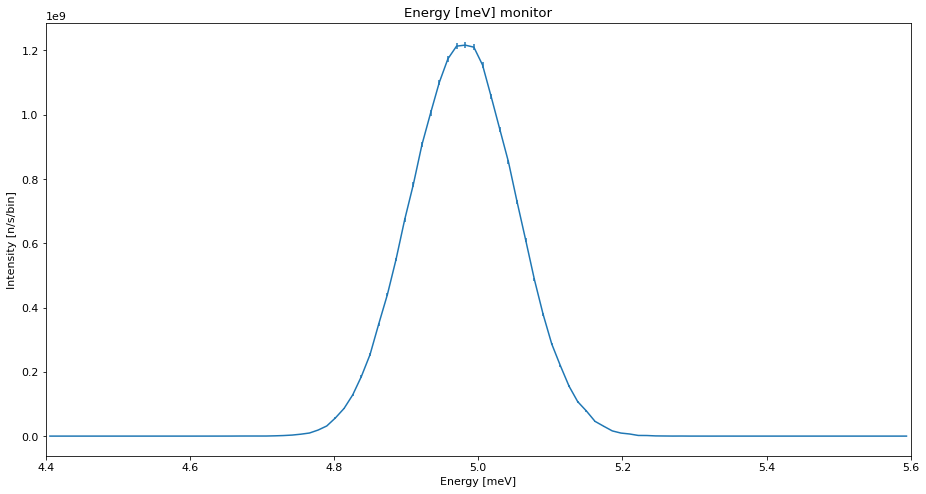

Plotting data with name mono_out_rot_DEBUG


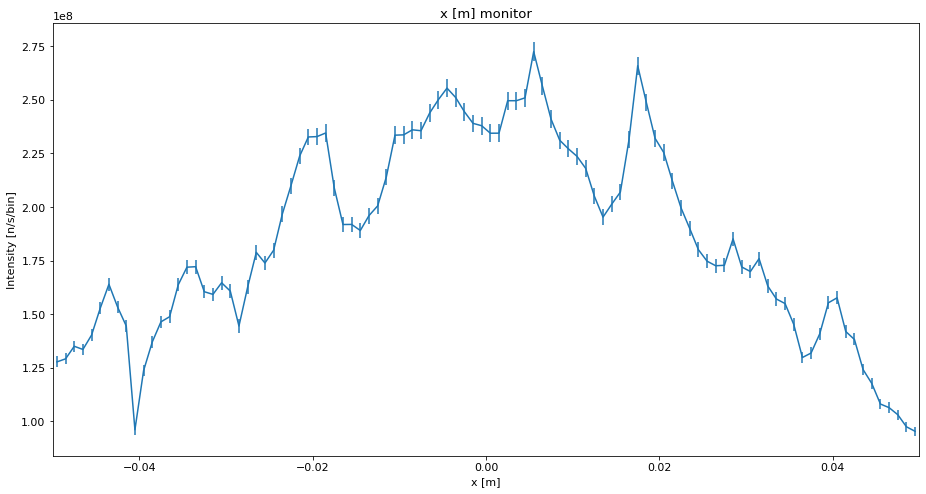

Plotting data with name mono_out_rot_DEBUG


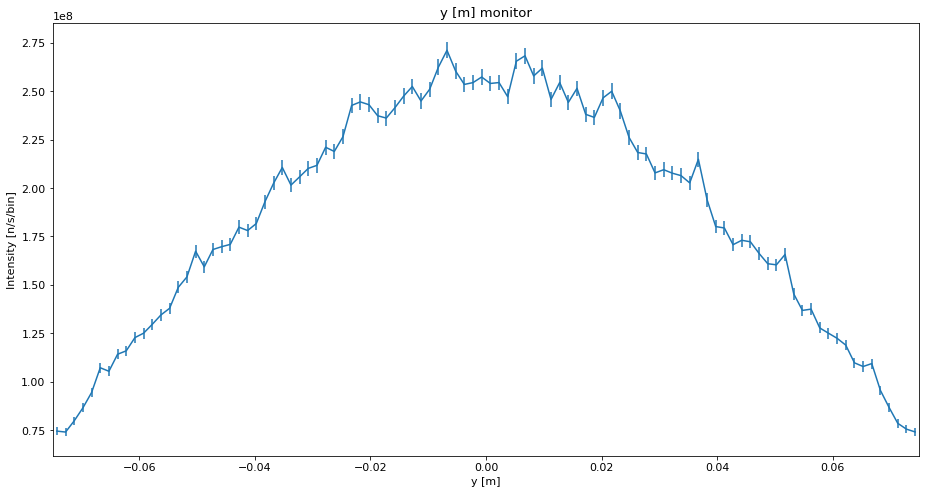

Plotting data with name mono_out_rot_psd_DEBUG


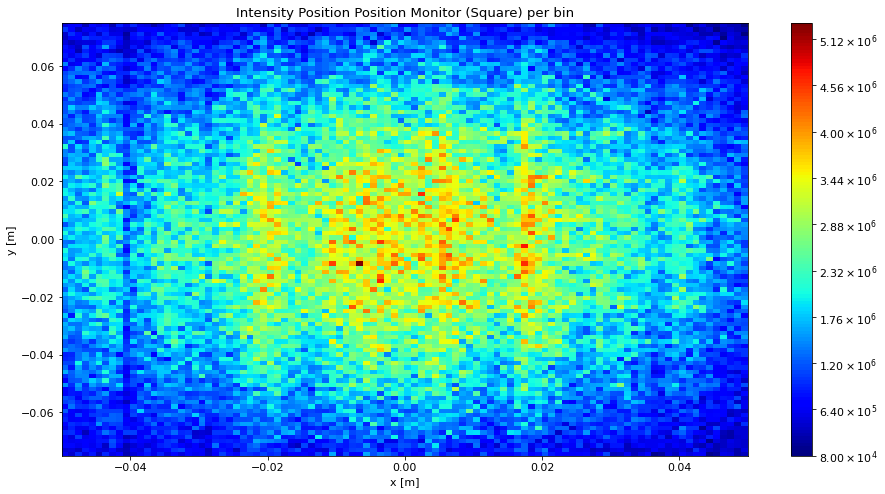

Plotting data with name mono_out_rot_psdcyl_DEBUG


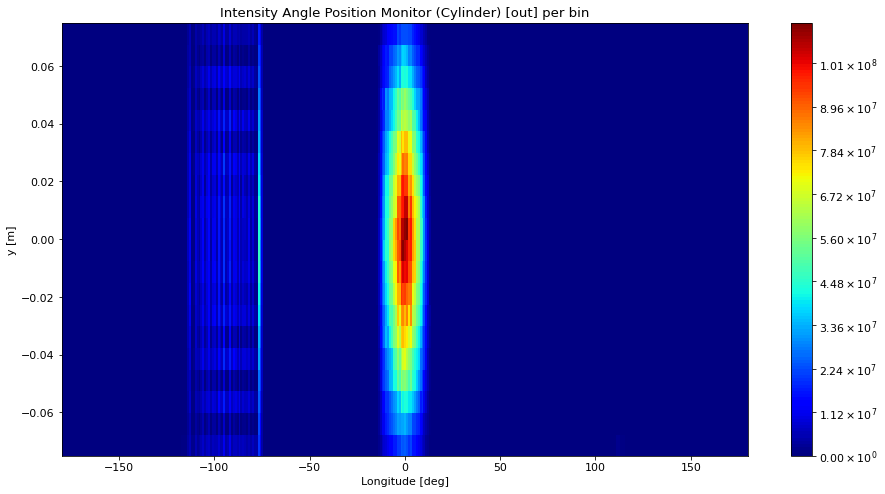

Plotting data with name sample_DEBUG


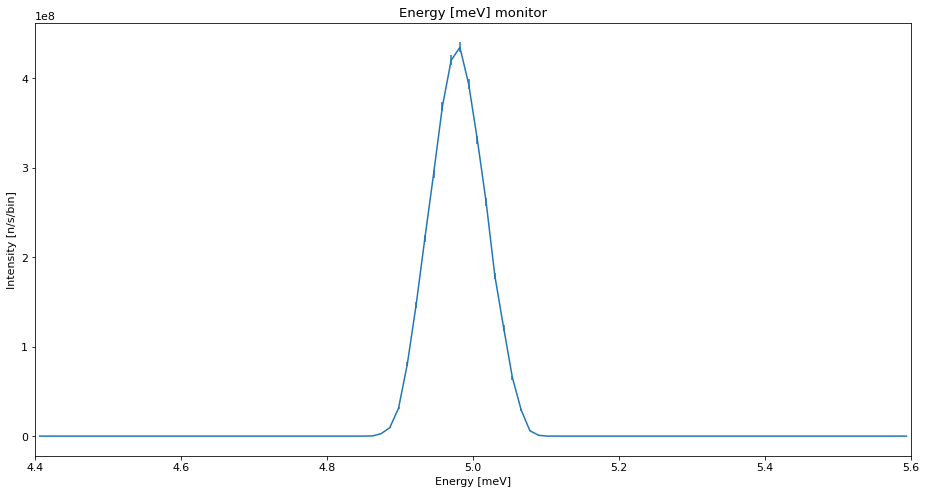

Plotting data with name sample_DEBUG


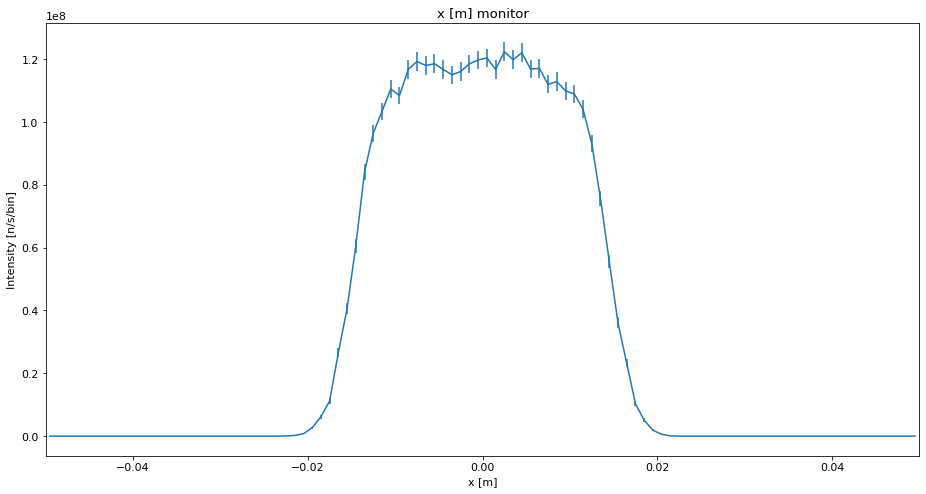

Plotting data with name sample_DEBUG


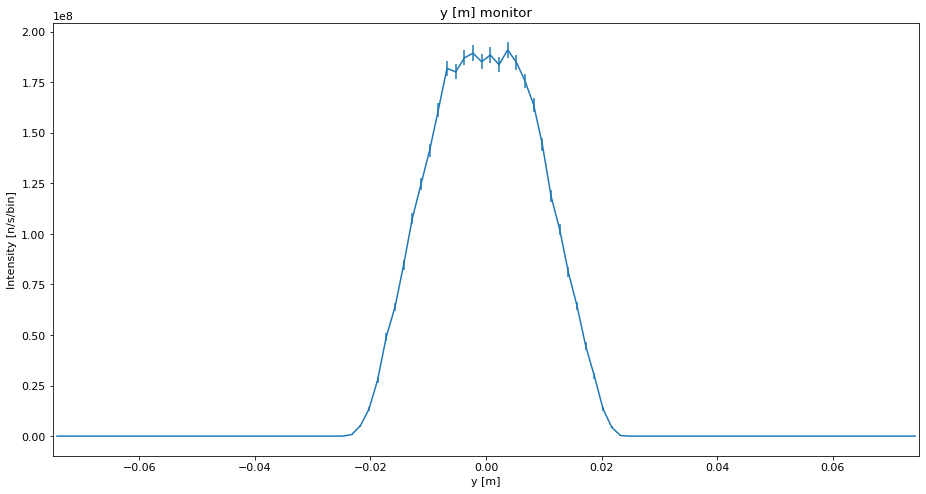

Plotting data with name sample_psd_DEBUG


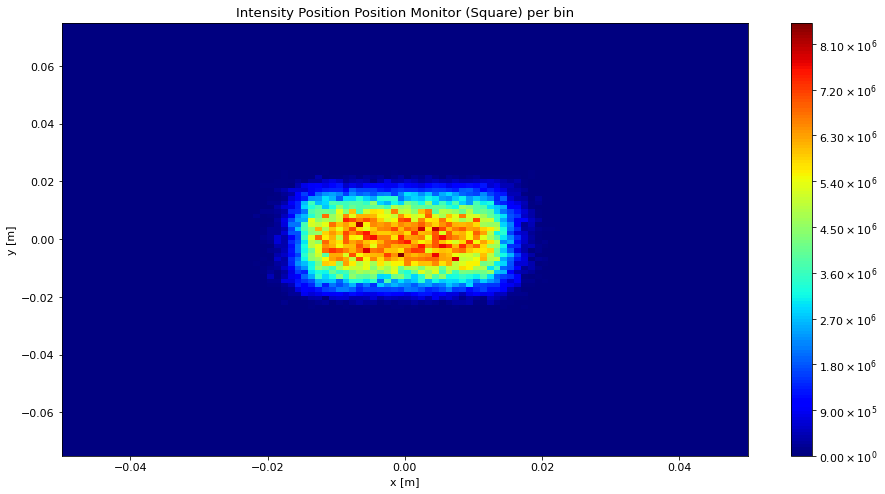

Plotting data with name sample_psdcyl_DEBUG


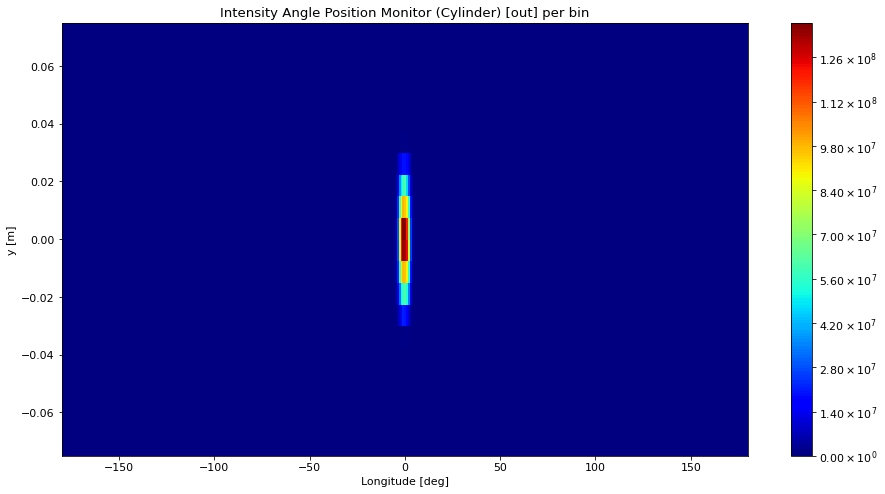

Plotting data with name 10T_logger_space_zx


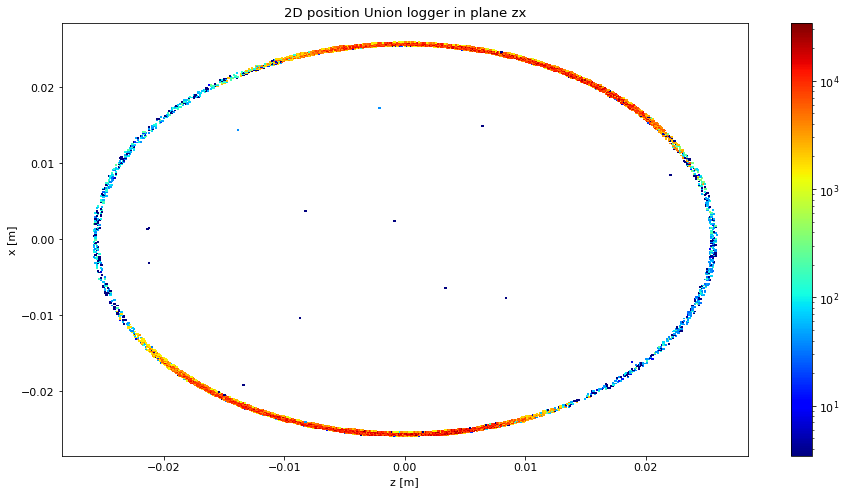

Plotting data with name 10T_logger_space_zy


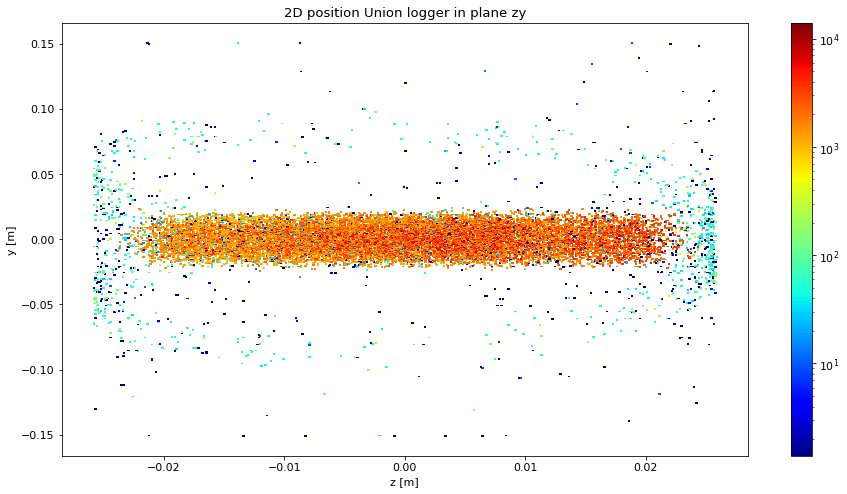

Plotting data with name 10T_logger_space_xy


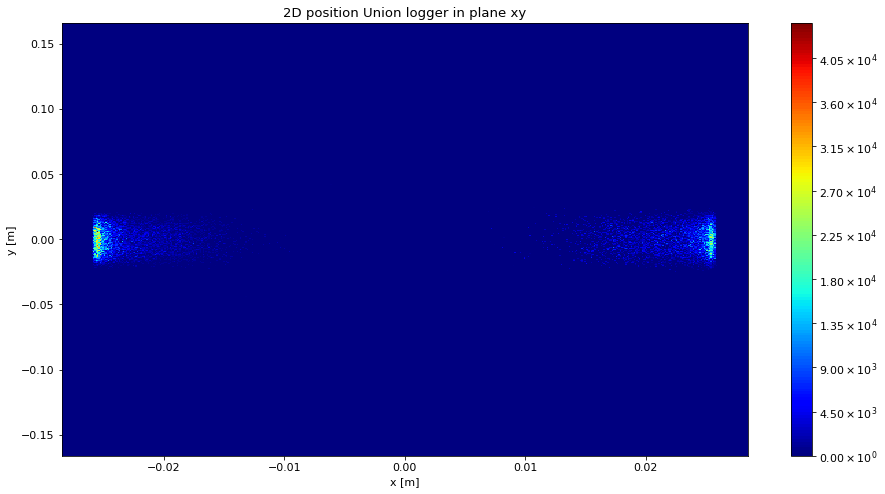

Plotting data with name 10T_logger_space_zy_close


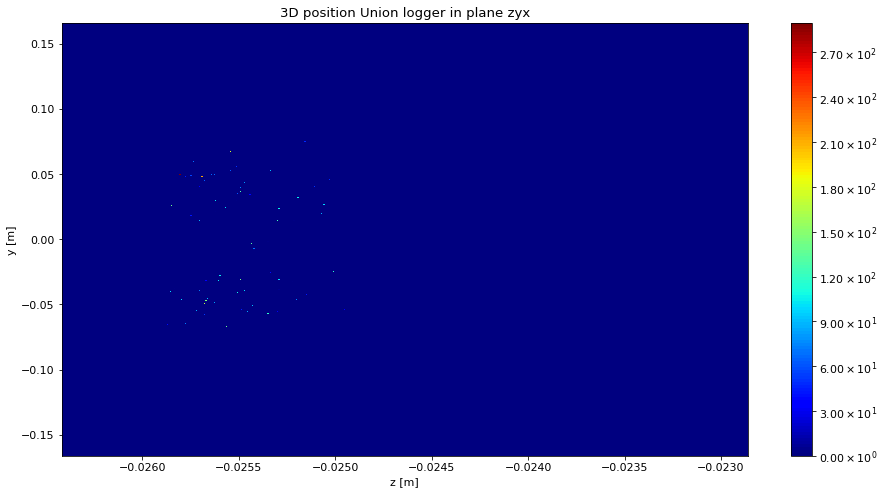

In [10]:
#print(data_empty)
for d in data_empty:
  ms.make_sub_plot(d)


Plotting data with name sample_psd_DEBUG
Plotting data with name sample_psdcyl_DEBUG
Plotting data with name 10T_logger_space_zx
Plotting data with name 10T_logger_space_zy
Plotting data with name 10T_logger_space_xy
Plotting data with name 10T_logger_space_zy_close


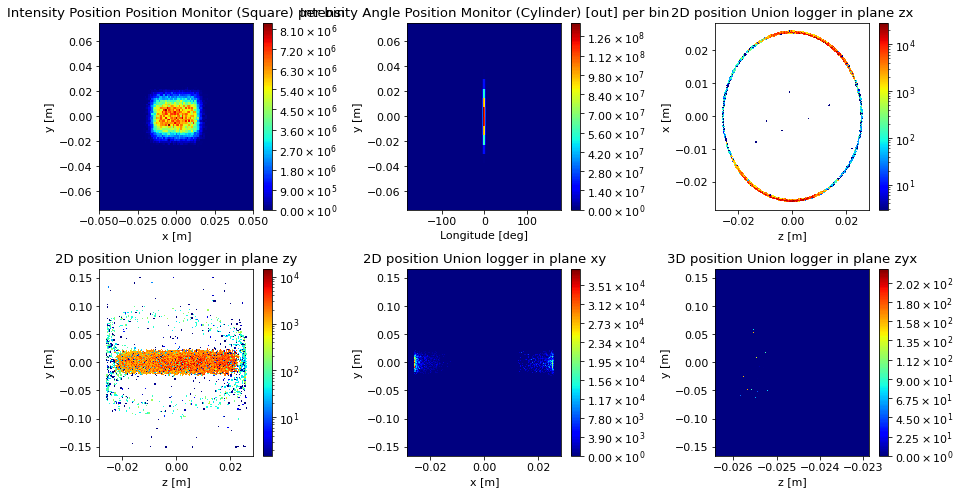

In [9]:
ms.make_sub_plot(data_empty[48:54])
#ms.make_sub_plot(data_empty[2])

Plotting data with name sample_out_DEBUG
Plotting data with name sample_out_DEBUG
Plotting data with name sample_out_psd_DEBUG
Plotting data with name sample_out_psdcyl_DEBUG


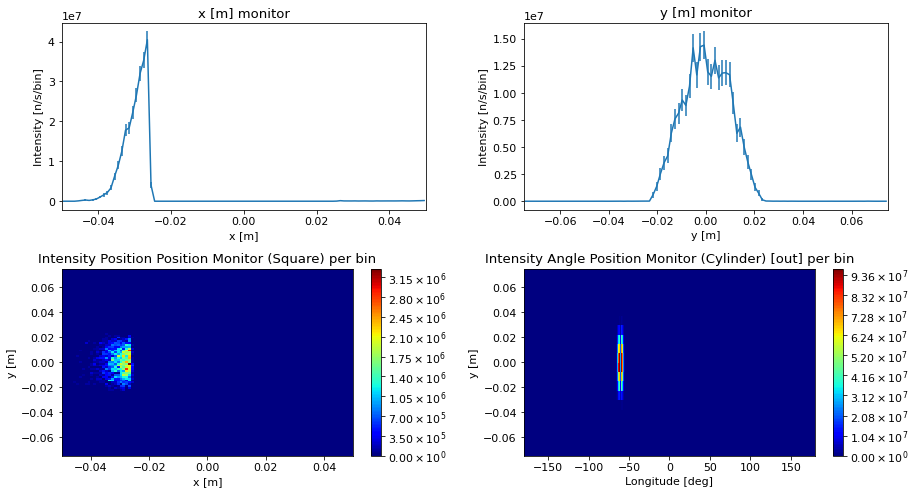

In [10]:
ms.make_sub_plot(data_empty[55:])